Import packages

In [554]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, plot, iplot
import sqlite3
import Code.Preparation as prep
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import re
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

### Clean and combine happiness reports dataset

Load datasets

In [763]:
df2021 = pd.read_csv(prep.path('happy/2021.csv'))
df2021['Year'] = 2021

In [764]:
dfhappy = pd.read_csv(prep.path('happy/world-happiness-report.csv'))

In [765]:
dfhappy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1949 non-null   object 
 1   year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float64
 3   Log GDP per capita                1913 non-null   float64
 4   Social support                    1936 non-null   float64
 5   Healthy life expectancy at birth  1894 non-null   float64
 6   Freedom to make life choices      1917 non-null   float64
 7   Generosity                        1860 non-null   float64
 8   Perceptions of corruption         1839 non-null   float64
 9   Positive affect                   1927 non-null   float64
 10  Negative affect                   1933 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 167.6+ KB


Change names to match corresponding columns and merge dataframes

In [766]:
df2021 = df2021[['Country name','Year', 'Ladder score','Social support','Healthy life expectancy','Logged GDP per capita','Freedom to make life choices','Generosity','Perceptions of corruption']]
df2021 = df2021.rename(columns={'Year': 'year', 'Ladder score': 'Life Ladder', 'Healthy life expectancy': 'Healthy life expectancy at birth', 'Logged GDP per capita': 'Log GDP per capita'})
dfhappy = dfhappy.merge(df2021, how='outer').drop(columns=['Positive affect', 'Negative affect'])

Check for null values

In [767]:
dfhappy.isna().sum()

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         32
Generosity                           89
Perceptions of corruption           110
dtype: int64

Interpolate null values

In [768]:
dfhappy = dfhappy.interpolate()

In [770]:
# Export dataset to csv
dfhappy.to_csv('Data/CleanedHappy.csv')

### World Dataset

In [535]:
datadf = pd.read_csv(prep.path('WDI/WDIData.csv'))
countrydf = pd.read_csv(prep.path('WDI/WDICountry.csv'))
df = pd.read_csv(prep.path('World_Development/Indicators.csv'))

In [536]:
Indicator_array =  df[['IndicatorName','IndicatorCode']].drop_duplicates().values

In [537]:
modified_indicators = []
unique_indicator_codes = []
for ele in Indicator_array:
    indicator = ele[0]
    indicator_code = ele[1].strip()
    if indicator_code not in unique_indicator_codes:
        # delete , ( ) from the IndicatorNames
        new_indicator = re.sub('[,()]',"",indicator).lower()
        # replace - with "to" and make all words into lower case
        new_indicator = re.sub('-'," to ",new_indicator).lower()
        modified_indicators.append([new_indicator,indicator_code])
        unique_indicator_codes.append(indicator_code)

Indicators = pd.DataFrame(modified_indicators,columns=['IndicatorName','IndicatorCode'])
Indicators = Indicators.drop_duplicates()
print(Indicators.shape)

(1344, 2)


In [593]:
key_word_dict = {}
key_word_dict['Demography'] = ['population','birth','death','fertility','mortality','expectancy']
key_word_dict['Food'] = ['food','grain','nutrition','calories']
key_word_dict['Trade'] = ['trade','import','export','good','shipping','shipment']
key_word_dict['Health'] = ['health','desease','hospital','mortality','doctor']
key_word_dict['Economy'] = ['income','gdp','gni','deficit','budget','market','stock','bond','infrastructure']
key_word_dict['Energy'] = ['fuel','energy','power','emission','electric','electricity']
key_word_dict['Education'] = ['education','literacy']
key_word_dict['Employment'] =['employed','employment','umemployed','unemployment']
key_word_dict['Rural'] = ['rural','village']
key_word_dict['Urban'] = ['urban','city']
key_word_dict['Social Programs'] = ['social', 'welfare']

In [594]:
feature = 'Social Programs'
for indicator_ele in Indicators.values:
    for ele in key_word_dict[feature]:
        word_list = indicator_ele[0].split()
        if ele in word_list or ele+'s' in word_list:
            # Uncomment this line to print the indicators explicitely
            print(indicator_ele)
            break

['social contributions % of revenue' 'GC.REV.SOCL.ZS']
['social contributions current lcu' 'GC.REV.SOCL.CN']
['adequacy of social insurance programs % of total welfare of beneficiary households'
 'per_si_allsi.adq_pop_tot']
['adequacy of social protection and labor programs % of total welfare of beneficiary households'
 'per_allsp.adq_pop_tot']
['adequacy of unemployment benefits and almp % of total welfare of beneficiary households'
 'per_lm_alllm.adq_pop_tot']
['benefits incidence in poorest quintile %  to  all social insurance'
 'per_si_allsi.ben_q1_tot']
['benefits incidence in poorest quintile %  to all social protection and labor'
 'per_allsp.ben_q1_tot']
['coverage %  to  all social insurance' 'per_si_allsi.cov_pop_tot']
['coverage %  to all social protection and labor' 'per_allsp.cov_pop_tot']
['coverage %  to  all social assistance' 'per_sa_allsa.cov_pop_tot']
['adequacy of social safety net programs % of total welfare of beneficiary households'
 'per_sa_allsa.adq_pop_tot']
['

In [555]:
# Main indicators to compare contries
chosen_indicators = ['GC.REV.SOCL.ZS',  \
                     'GC.REV.SOCL.CN', 'IQ.CPA.PROT.XQ', 'IQ.CPA.SOCI.XQ']

# Subset of data with the required features alone
df_subset = df[df['IndicatorCode'].isin(chosen_indicators)]


df_Arg = df_subset[df['CountryName']=="Argentina"]
df_usa = df_subset[df['CountryName']=="United States"]

# PLotting function for comparing development indicators
def plot_indicator(indicator,delta=10):
    ds_Arg = df_Arg[['IndicatorName','Year','Value']][df_Arg['IndicatorCode']==indicator]
    try:
        title = ds_Arg['IndicatorName'].iloc[1]
    except:
        title = "None"

    xArg = ds_Arg['Year'].values
    yArg = ds_Arg['Value'].values
    ds_usa = df_usa[['IndicatorName','Year','Value']][df_usa['IndicatorCode']==indicator]
    xusa = ds_usa['Year'].values
    yusa = ds_usa['Value'].values
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(121)
    plt.plot(xArg,yArg,label='Argentina')
    plt.plot(xusa,yusa,label='USA')
    plt.title(title)
    plt.legend(loc=2)

    plt.subplot(122)
    plt.plot(xArg,yArg,label='Argentina')
    plt.plot(xusa+delta,yusa,label='USA')
    plt.title(title + "\n USA Data Shifted by " +str(delta)+" Years")
    plt.legend(loc=2)

In [689]:
df_subset.IndicatorName.value_counts()

Social contributions (% of revenue)                                            1584
Social contributions (current LCU)                                             1398
CPIA policies for social inclusion/equity cluster average (1=low to 6=high)    1018
CPIA social protection rating (1=low to 6=high)                                1015
Name: IndicatorName, dtype: int64

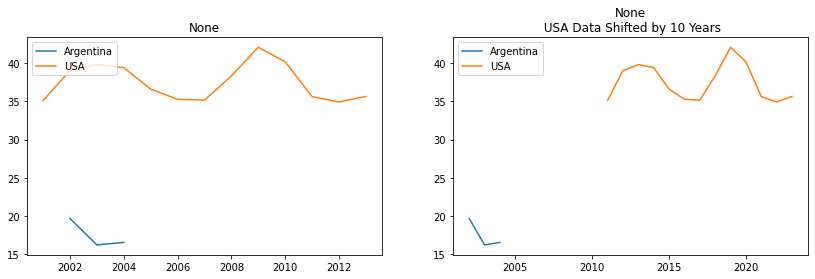

In [556]:
plot_indicator(chosen_indicators[0],delta=10)

In [15]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422136 entries, 0 to 422135
Data columns (total 64 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    422136 non-null  object 
 1   Country Code    422136 non-null  object 
 2   Indicator Name  422136 non-null  object 
 3   Indicator Code  422136 non-null  object 
 4   1960            38296 non-null   float64
 5   1961            42017 non-null   float64
 6   1962            44198 non-null   float64
 7   1963            44084 non-null   float64
 8   1964            44611 non-null   float64
 9   1965            47305 non-null   float64
 10  1966            46902 non-null   float64
 11  1967            48633 non-null   float64
 12  1968            48209 non-null   float64
 13  1969            50011 non-null   float64
 14  1970            92892 non-null   float64
 15  1971            99126 non-null   float64
 16  1972            101898 non-null  float64
 17  1973      

In [771]:
worlddf = pd.DataFrame(datadf.groupby(['Country Name','Indicator Name']).mean().stack())
worlddf = worlddf.reset_index()
worlddf = worlddf.rename(columns={0: 'Value', 'level_2': 'Year', 'Country Name': 'Country', 'Indicator Name': 'IndicatorName'})
# worlddf['Year'] = worlddf['Year'].astype(str)
# worlddf['Year'] = pd.to_datetime(worlddf['Year'])
worlddf = worlddf[worlddf.Year >= '1985']

In [772]:
worlddf.to_csv('Data/WorldDf.csv')

In [557]:
ar_1 = ARIMA(arg, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

Year
1985-01-01     0.000000
1985-01-01    55.648247
1985-01-01    31.367922
1985-01-01    15.060333
1985-01-01     9.845779
                ...    
2014-01-01     4.277823
2014-01-01     3.684827
2014-01-01     3.265107
2014-01-01     2.174381
2014-01-01     1.193129
Name: predicted_mean, Length: 120, dtype: float64

In [558]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      suicides/100k pop   No. Observations:                  120
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -459.609
Date:                Wed, 24 Nov 2021   AIC                            923.217
Time:                        15:37:23   BIC                            928.776
Sample:                             0   HQIC                           925.474
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2257      0.083     -2.723      0.006      -0.388      -0.063
sigma2       132.4505      7.781     17.021      0.000     117.199     147.702
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               460.25
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             2.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""